### Задание1: 
Модифицировать реализацию линейной регрессии из предыдущего урока, добавив l2 регулярязационную поправку к штрафной функции: +𝑐∗∑(𝑤_j)^2 и соответствующую к выражению для производной. Опробовать реализацию на примере с полиномиальными фичами 6го порядка из данного урока. При каком значении С в воспроизводимой функции не будет воспроизводить несуществующий минимум в окрестностях x=7,5?

Добвим в функционал ошибки l2 регулярязационную поправку.

$Q(a,x) = \frac{1}{l}\sum\limits_{i = 1}^l {(a(} {x_i}) - {y_i}{)^2} + \lambda  \cdot \sum\limits_{i = 1}^l {{w_i}^2} $

Градиент функционала ошибки Q(w,X), для многомерной регрессии будет иметь вид:
$${\nabla _w}Q(w,X) = 2\left( {\frac{1}{l}{X^T}\left( {Xw - y} \right) + \lambda  \cdot w} \right).$$

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

In [6]:
# реализуем функцию, определяющую среднеквадратичную ошибку
def mserror(X, w, y_pred, r = 0.02):
    y = X.dot(w)
    return (sum((y - y_pred)**2)) / len(y) + r*sum(w**2)

In [7]:
def generate_features(x, max_power):
    x=x[:, np.newaxis]
    return np.concatenate([x**i for i in range(1, max_power+1)], axis=1)

In [8]:
def polynomial(coef, x, max_power):
    X = generate_features(x, max_power)
    return np.dot(X, coef.T)

**Модифицируем код с учетом L2 регуляризации**

In [98]:

    def linear_regression(w, X, Y, r=10, max_iter=1e4, alpha=1e-6, min_weight_dist=1e-8):
        """
        alpha - шаг градиентного спуска
        w - начальные веса
        r - коэффициент регуляризации
        max_iter - максимальное число итераций
        min_weight_dist - критерий сходимости (разница весов, при которой алгоритм останавливается)
        """
        #список векторов весов после каждой итерации
        w_list = [w.copy()]

        # список значений ошибок после каждой итерации
        errors = []

        # зададим начальную разницу весов большим числом
        weight_dist = np.inf

        # счетчик итераций
        iter_num = 0

        # ход градиентного спуска
        while weight_dist > min_weight_dist and iter_num < max_iter:
            new_w = w - alpha * 2 *(np.dot(X.T, (np.dot(X, w) - Y)) / Y.shape[0] + r*w)
            weight_dist = np.linalg.norm(new_w - w, ord=2)
            iter_num += 1
            w = new_w
        w_list = np.array(w_list)
        print(f"количество итераций {iter_num}")
        return {"coef":new_w}

In [99]:
def f(x):
    return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3

dots = np.linspace(-10, 10, 100)
np.random.seed(16)
x_data = np.random.uniform(-10, 10, 20)
f_data = [f(i) for i in x_data] + np.random.uniform(-2000, 2000, 20)
# возьмем нулевые начальные веса
w = np.zeros(6)
X = generate_features(x_data, 6)


In [100]:
coef = linear_regression(w, X, f_data, alpha=1e-11, r=1e5, min_weight_dist=1e-4)
coef['coef']

количество итераций 171


array([-6.88126919e-06, -4.46866624e-06, -5.29112925e-04,  9.44215185e-05,
       -3.89683835e-02,  1.50491472e-03])

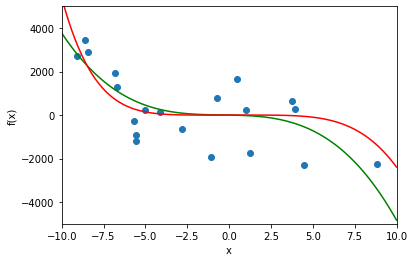

In [582]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)
plt.plot(dots, polynomial(coef['coef'], dots, 6), color='r')


In [394]:
def play_model(_x, model):
    data=generate_features(_x, len(model.coef_))
    return (data.dot(model.coef_[:, np.newaxis])+model.intercept_).flatten()

### Задание2:
Модифицировать пример со стохастическим градиентом из этого урока, реализовав в нём рассчёт градиента по десяти случайно выбираемым объектам (mini-batch градиент).

In [77]:
def random_objects(X,Y,size=10):
    """
    Функция возвращает некоторое количество случайных строк, заданных параметром size из массива, заданного параметром X. 
    """
    if X.shape[0] < size:
        raise Exception(f"параметр size = {size}, не должен быть больше количества строк = {X.shape[0]}, переданного массива ")
    index_ = np.random.randint(X.shape[0], size=size)
    return {"X":np.array([X[i] for i in index_]), "Y":np.array([Y[i] for i in index_])}

In [79]:
a = random_objects(X,f_data,size=10)

In [95]:
def linear_regression_stochastic(w, X, Y, batch=1, r=0, max_iter=1e4, alpha=1e-6, min_weight_dist=1e-8):
        """
        batch - количество выбираемых объектов
        alpha - шаг градиентного спуска
        w - начальные веса
        r - коэффициент регуляризации
        max_iter - максимальное число итераций
        min_weight_dist - критерий сходимости (разница весов, при которой алгоритм останавливается)
        """
        #список векторов весов после каждой итерации
        w_list = [w.copy()]

        # список значений ошибок после каждой итерации
        errors = []

        # зададим начальную разницу весов большим числом
        weight_dist = np.inf

        # счетчик итераций
        iter_num = 0
        
        np.random.seed(1234)

        # ход градиентного спуска
        while weight_dist > min_weight_dist and iter_num < max_iter:
            a = random_objects(X,Y,batch)
            X_ = a['X']
            Y_ = a['Y']
            new_w = w - alpha * 2 *(np.dot(X_.T, (np.dot(X_, w) - Y_)) / Y_.shape[0] + r*w)
            weight_dist = np.linalg.norm(new_w - w, ord=2)
            iter_num += 1
            w = new_w
        w_list = np.array(w_list)
        print(f"количество итераций {iter_num}")
        return {"coef":new_w}

In [96]:
w = np.zeros(6)
X = generate_features(x_data, 6)
coef = linear_regression_stochastic(w, X, f_data, batch=10, alpha=1e-11, r=0, min_weight_dist=1e-5)

количество итераций 248


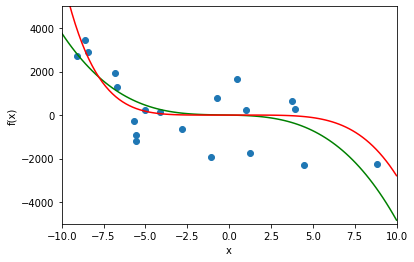

In [97]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)
plt.plot(dots, polynomial(coef['coef'], dots, 6), color='r')